In [12]:
!pip install torch-fidelity

In [13]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torchvision.models import inception_v3
import torchvision.transforms as T
import torchvision.transforms.functional as TF

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors

from tqdm import tqdm

# Optional: Try to import torchmetrics, install if not available
try:
    from torchmetrics.image.fid import FrechetInceptionDistance
except ImportError:
    print("Installing torchmetrics...")
    !pip install torchmetrics scikit-learn matplotlib
    from torchmetrics.image.fid import FrechetInceptionDistance

# Check 1: Is CUDA available now?
cuda_available = torch.cuda.is_available()
print(f"torch.cuda.is_available(): {cuda_available}")

if cuda_available:
    # Check 2: Are PyTorch and the driver communicating?
    try:
        device_name = torch.cuda.get_device_name(0)
        print(f"Detected GPU: {device_name}")

        # Check 3: Is a simple device operation possible?
        tensor_on_gpu = torch.randn(1, 1).to('cuda')
        print(f"Successfully placed tensor on device: {tensor_on_gpu.device}")

    except Exception as e:
        print(f"Detailed GPU check failed: {e}")
        # If this fails, you still have a driver/installation issue.
else:
    print("FATAL: GPU is not accessible. Please check your runtime settings.")

torch.cuda.is_available(): True
Detected GPU: Tesla T4
Successfully placed tensor on device: cuda:0


In [14]:
# Configuration
T_MAX = 1000
T_TRUNC = 10
BATCH_SIZE = 128
IMAGE_CHANNELS = 3
IMAGE_SIZE = 32
LATENT_DIM = 128
EPOCHS_PRIOR = 16 # OPTIMIZATION: REDUCED EPOCHS FOR SPEED***

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
OUTPUT_DIR = './T_trunc_dataset'
SAVE_PATH = os.path.join(OUTPUT_DIR, f'target_x_T_{T_TRUNC}.pt')

os.makedirs(OUTPUT_DIR, exist_ok=True)

# FAST EXIT IF DATA ALREADY EXISTS
if os.path.exists(SAVE_PATH):
    print(f"\nFound existing dataset at {SAVE_PATH}")
    x_T_trunc_dataset = torch.load(SAVE_PATH, map_location="cpu")
    print(f"Loaded dataset shape: {x_T_trunc_dataset.shape}")

else:
    # 1. Load CIFAR-10
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5),
                             (0.5, 0.5, 0.5))
    ])

    dataset = datasets.CIFAR10(
        root='./data',
        train=True,
        download=True,
        transform=transform
    )

    train_loader = DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )

    print(f"Loaded training dataset: {len(dataset)} samples.")

    # 2. DDPM Forward Process
    class DDPMForward:
        def __init__(self, t_max):
            self.betas = torch.linspace(1e-4, 2e-2, t_max, device=DEVICE)
            self.alphas = 1.0 - self.betas
            self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
            self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
            self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)

        def forward_diffusion(self, x_0, t):
            if isinstance(t, int):
                t = torch.full(
                    (x_0.size(0),),
                    t,
                    device=DEVICE,
                    dtype=torch.long
                )

            t_idx = t - 1
            sqrt_alpha_bar = self.sqrt_alphas_cumprod[t_idx].view(-1, 1, 1, 1)
            sqrt_one_minus_alpha_bar = self.sqrt_one_minus_alphas_cumprod[t_idx].view(-1, 1, 1, 1)

            noise = torch.randn_like(x_0)
            return sqrt_alpha_bar * x_0 + sqrt_one_minus_alpha_bar * noise

    ddpm_forward = DDPMForward(T_MAX)

    # 3. Generate x_T_trunc Dataset
    x_T_trunc_list = []

    print(f"\n--- Generating x_T_trunc for T={T_TRUNC} ---")

    with torch.no_grad():
        for images, _ in tqdm(train_loader, desc="Forward Diffusion"):
            images = images.to(DEVICE, non_blocking=True)
            x_T = ddpm_forward.forward_diffusion(images, T_TRUNC)
            x_T_trunc_list.append(x_T.cpu())

    x_T_trunc_dataset = torch.cat(x_T_trunc_list, dim=0)
    torch.save(x_T_trunc_dataset, SAVE_PATH)

    print(f"\nDataset saved to {SAVE_PATH}")
    print(f"Final dataset shape: {x_T_trunc_dataset.shape}")




Found existing dataset at ./T_trunc_dataset/target_x_T_10.pt
Loaded dataset shape: torch.Size([50000, 3, 32, 32])


In [15]:
# Training the prior models on the CIFAR-10 dataset.

def sliced_wasserstein_distance(fake_samples, real_samples, num_projections, p=2, device='cpu'):
    """
    Computes the Sliced Wasserstein Distance (SWD) between two sets of samples.
    """
    # Flatten images: (N, C, H, W) -> (N, D)
    batch_size = fake_samples.size(0)
    dim = fake_samples.view(batch_size, -1).size(1)

    fake_flat = fake_samples.view(batch_size, -1)
    real_flat = real_samples.view(batch_size, -1)

    # Generate random projections
    projections = torch.randn((dim, num_projections), device=device)
    projections = projections / torch.sqrt(torch.sum(projections ** 2, dim=0, keepdim=True))

    # Project the data
    fake_projections = fake_flat @ projections
    real_projections = real_flat @ projections

    # Sort the projections (1D Wasserstein)
    fake_sorted, _ = torch.sort(fake_projections, dim=0)
    real_sorted, _ = torch.sort(real_projections, dim=0)

    # Compute distance
    if p == 1:
        dist = torch.abs(fake_sorted - real_sorted)
    else:
        dist = torch.pow(torch.abs(fake_sorted - real_sorted), p)

    return torch.mean(dist)

print("OT Configuration: Using Sliced Wasserstein Distance (SWD) implemented in PyTorch.")
print(f"Device: {DEVICE}")
print(f"Training Epochs set to: {EPOCHS_PRIOR}")

## 1. Data Loading and Custom Dataset

class TruncatedDiffusionDataset(Dataset):
    def __init__(self, data_tensor):
        self.data = data_tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

trunc_dataloader = None # Initialize variable to prevent уerrors

try:
    if os.path.exists(SAVE_PATH):
        x_T_trunc_dataset = torch.load(SAVE_PATH)
        trunc_dataset = TruncatedDiffusionDataset(x_T_trunc_dataset)
        # Data will be moved to DEVICE in the training loop batch by batch
        trunc_dataloader = DataLoader(trunc_dataset, batch_size=BATCH_SIZE, shuffle=True)
        print(f"Loaded target dataset of shape {x_T_trunc_dataset.shape} for prior training.")
    else:
        print(f"ERROR: Target noisy dataset not found at {SAVE_PATH}. Training will be skipped.")
except Exception as e:
    print(f"Error loading dataset: {e}")


## 2. Shared Network Architecture

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(LATENT_DIM, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512), nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256), nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128), nn.ReLU(True),
            nn.ConvTranspose2d(128, IMAGE_CHANNELS, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    def forward(self, z):
        return self.main(z.view(-1, LATENT_DIM, 1, 1))

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(IMAGE_CHANNELS, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(IMAGE_CHANNELS, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 1, 0, bias=False)
        )
        self.fc_mu = nn.Linear(512, LATENT_DIM)
        self.fc_logvar = nn.Linear(512, LATENT_DIM)

    def forward(self, x):
        h = self.features(x)
        h = h.view(-1, 512)
        return self.fc_mu(h), self.fc_logvar(h)

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


OT Configuration: Using Sliced Wasserstein Distance (SWD) implemented in PyTorch.
Device: cuda
Training Epochs set to: 16
Loaded target dataset of shape torch.Size([50000, 3, 32, 32]) for prior training.


In [16]:

#VAE PRIOR

class VAE(nn.Module):
    def __init__(self, beta=1.0):
        super().__init__()
        self.encoder = Encoder().to(DEVICE)
        self.decoder = Generator().to(DEVICE)
        self.beta = beta

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.reparameterize(mu, log_var)
        return self.decoder(z), mu, log_var


VAE_Prior = VAE(beta=0.05).to(DEVICE)
VAE_Prior.apply(weights_init)

optimizer_vae = optim.Adam(VAE_Prior.parameters(), lr=2e-4)
recon_loss = nn.L1Loss(reduction="mean")

print("\n--- Training FIXED VAE Prior ---")
for epoch in range(EPOCHS_PRIOR):
    total_loss = 0
    for data in tqdm(trunc_dataloader, desc=f"VAE Epoch {epoch+1}"):
        data = data.to(DEVICE)
        optimizer_vae.zero_grad()

        recon, mu, log_var = VAE_Prior(data)

        # Reconstruction loss (per pixel, averaged)
        RL = recon_loss(recon, data)

        KLD = -0.5 * torch.sum(
            1 + log_var - mu.pow(2) - log_var.exp(),
            dim=1
        ).mean()

        loss = RL + VAE_Prior.beta * KLD
        loss.backward()
        optimizer_vae.step()

        total_loss += loss.item()

    print(f"VAE Epoch {epoch+1}: Loss = {total_loss/len(trunc_dataloader):.4f}")

torch.save(VAE_Prior.state_dict(), f"VAE_Prior_T{T_TRUNC}.pth")



--- Training FIXED VAE Prior ---


VAE Epoch 1: 100%|██████████| 391/391 [00:17<00:00, 21.88it/s]


VAE Epoch 1: Loss = 0.4488


VAE Epoch 2: 100%|██████████| 391/391 [00:17<00:00, 22.68it/s]


VAE Epoch 2: Loss = 0.4095


VAE Epoch 3: 100%|██████████| 391/391 [00:16<00:00, 24.29it/s]


VAE Epoch 3: Loss = 0.4066


VAE Epoch 4: 100%|██████████| 391/391 [00:16<00:00, 24.24it/s]


VAE Epoch 4: Loss = 0.4061


VAE Epoch 5: 100%|██████████| 391/391 [00:15<00:00, 24.66it/s]


VAE Epoch 5: Loss = 0.4052


VAE Epoch 6: 100%|██████████| 391/391 [00:16<00:00, 24.39it/s]


VAE Epoch 6: Loss = 0.4052


VAE Epoch 7: 100%|██████████| 391/391 [00:16<00:00, 23.79it/s]


VAE Epoch 7: Loss = 0.4040


VAE Epoch 8: 100%|██████████| 391/391 [00:16<00:00, 24.08it/s]


VAE Epoch 8: Loss = 0.3995


VAE Epoch 9: 100%|██████████| 391/391 [00:15<00:00, 24.50it/s]


VAE Epoch 9: Loss = 0.3949


VAE Epoch 10: 100%|██████████| 391/391 [00:16<00:00, 24.09it/s]


VAE Epoch 10: Loss = 0.3944


VAE Epoch 11: 100%|██████████| 391/391 [00:15<00:00, 24.51it/s]


VAE Epoch 11: Loss = 0.3934


VAE Epoch 12: 100%|██████████| 391/391 [00:16<00:00, 24.39it/s]


VAE Epoch 12: Loss = 0.3935


VAE Epoch 13: 100%|██████████| 391/391 [00:16<00:00, 24.13it/s]


VAE Epoch 13: Loss = 0.3935


VAE Epoch 14: 100%|██████████| 391/391 [00:16<00:00, 24.25it/s]


VAE Epoch 14: Loss = 0.3926


VAE Epoch 15: 100%|██████████| 391/391 [00:16<00:00, 24.30it/s]


VAE Epoch 15: Loss = 0.3931


VAE Epoch 16: 100%|██████████| 391/391 [00:16<00:00, 24.28it/s]


VAE Epoch 16: Loss = 0.3928


In [17]:
# GAN PRIOR

class Discriminator_NoSigmoid(Discriminator):
    def __init__(self):
        super().__init__()
        self.main[-1] = nn.Identity()  # remove Sigmoid

NetG_GAN = Generator().to(DEVICE)
NetD_GAN = Discriminator_NoSigmoid().to(DEVICE)
NetG_GAN.apply(weights_init)
NetD_GAN.apply(weights_init)

optimizer_g = optim.Adam(NetG_GAN.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizer_d = optim.Adam(NetD_GAN.parameters(), lr=2e-4, betas=(0.5, 0.999))

criterion = nn.BCEWithLogitsLoss()
noise_std = 0.05  # instance noise

print("\n--- Training STABILIZED GAN Prior ---")
for epoch in range(EPOCHS_PRIOR):
    for data in tqdm(trunc_dataloader, desc=f"GAN Epoch {epoch+1}"):
        real = data.to(DEVICE)
        bsz = real.size(0)

        # Add instance noise
        real = real + noise_std * torch.randn_like(real)

        # Train Discriminator
        optimizer_d.zero_grad()

        real_labels = torch.full((bsz,), 0.9, device=DEVICE)  # label smoothing
        fake_labels = torch.zeros(bsz, device=DEVICE)

        real_logits = NetD_GAN(real)
        loss_real = criterion(real_logits, real_labels)

        z = torch.randn(bsz, LATENT_DIM, device=DEVICE)
        fake = NetG_GAN(z).detach()
        fake = fake + noise_std * torch.randn_like(fake)

        fake_logits = NetD_GAN(fake)
        loss_fake = criterion(fake_logits, fake_labels)

        loss_d = loss_real + loss_fake
        loss_d.backward()
        optimizer_d.step()

        # Train Generator
        optimizer_g.zero_grad()

        z = torch.randn(bsz, LATENT_DIM, device=DEVICE)
        fake = NetG_GAN(z)
        logits = NetD_GAN(fake)
        loss_g = criterion(logits, real_labels)

        loss_g.backward()
        optimizer_g.step()

    noise_std *= 0.8

torch.save(NetG_GAN.state_dict(), f"GAN_Prior_T{T_TRUNC}.pth")



--- Training STABILIZED GAN Prior ---


GAN Epoch 16: 100%|██████████| 391/391 [00:23<00:00, 16.51it/s]


In [18]:
# Metrics
class MetricsEvaluator:
    def __init__(self, device):
        self.device = device
        self.fid = FrechetInceptionDistance(feature=2048).to(device)
        self.start_time = 0
        self.end_time = 0

    def start_timer(self):
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        self.start_time = time.time()

    def stop_timer(self):
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        self.end_time = time.time()
        return self.end_time - self.start_time

    def update_real(self, imgs):
        imgs = ((imgs + 1) / 2 * 255).clamp(0, 255).byte()
        self.fid.update(imgs, real=True)

    def update_fake(self, imgs):
        imgs = ((imgs + 1) / 2 * 255).clamp(0, 255).byte()
        self.fid.update(imgs, real=False)

    def compute(self):
        return self.fid.compute().item()

    def reset(self):
        self.fid.reset()

# Generator
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(LATENT_DIM, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512), nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256), nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128), nn.ReLU(True),
            nn.ConvTranspose2d(128, IMAGE_CHANNELS, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        return self.main(z.view(-1, LATENT_DIM, 1, 1))


# Placeholder U-Net

class TinyTimeUNet(nn.Module):
    def __init__(self, img_channels, time_dim=128):
        super().__init__()

        self.time_embed = nn.Sequential(
            nn.Embedding(1000, time_dim),
            nn.Linear(time_dim, time_dim),
            nn.ReLU()
        )

        self.conv1 = nn.Conv2d(img_channels, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, img_channels, 3, padding=1)
        self.act = nn.ReLU()

    def forward(self, x, t):
        t_emb = self.time_embed(t).view(t.size(0), -1, 1, 1)
        h = self.act(self.conv1(x))
        h = h + t_emb[:, :h.size(1)]
        h = self.act(self.conv2(h))
        return self.conv3(h)

#DDPM Backbone
class DDPMBackbone:
    def __init__(self, device, t_max=1000):
        self.device = device
        self.t_max = t_max

        self.unet = TinyTimeUNet(IMAGE_CHANNELS).to(device)
        self.unet.eval()

        self.betas = torch.linspace(1e-4, 2e-2, t_max).to(device)
        self.alphas = 1.0 - self.betas
        self.alpha_bar = torch.cumprod(self.alphas, dim=0)
        self.alpha_bar_prev = torch.cat(
            [torch.tensor([1.0], device=device), self.alpha_bar[:-1]]
        )

        self.posterior_var = (
            self.betas * (1. - self.alpha_bar_prev) / (1. - self.alpha_bar)
        )

    def p_sample(self, x_t, t):
        beta_t = self.betas[t]
        alpha_t = self.alphas[t]
        alpha_bar_t = self.alpha_bar[t]

        eps = self.unet(x_t, t.expand(x_t.size(0)))

        mean = (1 / torch.sqrt(alpha_t)) * (
            x_t - (beta_t / torch.sqrt(1 - alpha_bar_t)) * eps
        )

        if t > 0:
            noise = torch.randn_like(x_t)
            return mean + torch.sqrt(self.posterior_var[t]) * noise
        return mean

    def reverse_loop(self, x_start, t_start):
        x = x_start
        for t in reversed(range(t_start)):
            x = self.p_sample(x, t)
        return x

# Inference Pipeline

class InferencePipeline:
    def __init__(self, ddpm):
        self.ddpm = ddpm
        self.priors = {}
        self.evaluator = MetricsEvaluator(ddpm.device)

    def load_prior(self, name, path):
        state = torch.load(path, map_location=self.ddpm.device)
        model = Generator().to(self.ddpm.device)

        if any(k.startswith("decoder.") for k in state.keys()):
            state = {
                k.replace("decoder.", ""): v
                for k, v in state.items()
                if k.startswith("decoder.main.")
            }

        model.load_state_dict(state)
        model.eval()
        self.priors[name] = model

    def generate(self, method, n_samples, t_trunc):
        self.evaluator.start_timer()

        if method == "Vanilla":
            x_start = torch.randn(
                n_samples, IMAGE_CHANNELS, IMAGE_SIZE, IMAGE_SIZE,
                device=self.ddpm.device
            )
        else:
            z = torch.randn(n_samples, LATENT_DIM, device=self.ddpm.device)
            with torch.no_grad():
                x_start = self.priors[method](z)

        with torch.no_grad():
            x_final = self.ddpm.reverse_loop(x_start, t_trunc)

        elapsed = self.evaluator.stop_timer()
        return x_final, elapsed

# Initialization

ddpm_backbone = DDPMBackbone(DEVICE, T_MAX)
pipeline = InferencePipeline(ddpm_backbone)

pipeline.load_prior("VAE", f"VAE_Prior_T{T_TRUNC}.pth")
pipeline.load_prior("GAN", f"GAN_Prior_T{T_TRUNC}.pth")
pipeline.load_prior("OT",  f"OT_Prior_T{T_TRUNC}.pth")


In [19]:
# Optimal Transport (OT) Enhanced Truncation for DDPM

try:
    from torchmetrics.image.fid import FrechetInceptionDistance
    print("torchmetrics (FID) loaded successfully.")
except ImportError:
    print("Installing torchmetrics and torch-fidelity for metric calculation...")
    !pip install torchmetrics torch-fidelity
    from torchmetrics.image.fid import FrechetInceptionDistance

class MetricsEvaluator:
    """
    Handles calculation of FID and Recall (placeholder for Recall).
    Uses TorchMetrics for standard FID calculation.
    """
    def __init__(self, device):
        self.device = device
        # Initialize FID metric (requires uint8 images in [0, 255])
        self.fid = FrechetInceptionDistance(feature=2048).to(device)
        self.start_time = 0
        self.end_time = 0

    def start_timer(self):
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        self.start_time = time.time()

    def stop_timer(self):
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        self.end_time = time.time()
        return self.end_time - self.start_time

    def update_real_images(self, real_images):
        """
        Feed real images to the FID calculator.
        Expects images in [-1, 1]. Converts to [0, 255] uint8.
        """
        # Denormalize from [-1, 1] to [0, 255]
        imgs = ((real_images + 1) / 2 * 255).clamp(0, 255).to(dtype=torch.uint8)
        self.fid.update(imgs, real=True)

    def update_fake_images(self, fake_images):
        """
        Feed generated images to the FID calculator.
        Expects images in [-1, 1]. Converts to [0, 255] uint8.
        """
        imgs = ((fake_images + 1) / 2 * 255).clamp(0, 255).to(dtype=torch.uint8)
        self.fid.update(imgs, real=False)

    def compute_fid(self):
        return self.fid.compute().item()

    def reset(self):
        self.fid.reset()

print("Metrics Evaluator configured.")

# Action: Create the master script that loads the frozen DDPM backbone and
# switches between priors to generate starting samples.

# 1. Define the Generator Architecture
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(LATENT_DIM, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512), nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256), nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128), nn.ReLU(True),
            nn.ConvTranspose2d(128, IMAGE_CHANNELS, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    def forward(self, z):
        return self.main(z.view(-1, LATENT_DIM, 1, 1))

# 2. Refine DDPM Backbone with Reverse Process Logic
class DDPMBackbone:
    def __init__(self, device, t_max=1000):
        self.device = device
        self.t_max = t_max

        self.time_embed = nn.Embedding(t_max, IMAGE_CHANNELS).to(device)
        self.unet = nn.Sequential(
            nn.Conv2d(IMAGE_CHANNELS, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, IMAGE_CHANNELS, 3, padding=1)
        ).to(device)

        self.betas = torch.linspace(0.0001, 0.02, t_max).to(device)
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        self.alphas_cumprod_prev = torch.cat(
            [torch.tensor([1.0], device=device), self.alphas_cumprod[:-1]]
        )
        self.posterior_variance = (
            self.betas * (1.0 - self.alphas_cumprod_prev) /
            (1.0 - self.alphas_cumprod)
        )

    def p_sample(self, x, t, t_index):
        beta_t = self.betas[t_index]
        sqrt_one_minus_alpha_cumprod_t = torch.sqrt(1 - self.alphas_cumprod[t_index])
        one_over_sqrt_alpha = 1 / torch.sqrt(self.alphas[t_index])

        t_emb = self.time_embed(t).view(t.size(0), -1, 1, 1)
        pred_noise = self.unet(x + t_emb)

        mean = one_over_sqrt_alpha * (
            x - (beta_t / sqrt_one_minus_alpha_cumprod_t) * pred_noise
        )

        if t_index > 0:
            noise = torch.randn_like(x)
            sigma_t = torch.sqrt(self.posterior_variance[t_index])
            return mean + sigma_t * noise
        else:
            return mean

    def reverse_loop(self, start_img, start_t_step):
        img = start_img
        for i in reversed(range(0, start_t_step)):
            t_tensor = torch.full(
                (img.shape[0],), i, device=self.device, dtype=torch.long
            )
            img = self.p_sample(img, t_tensor, i)
        return img


# 3. Master Inference Pipeline Class
class InferencePipeline:
    def __init__(self, ddpm_backbone):
        self.ddpm = ddpm_backbone
        self.priors = {}
        self.evaluator = MetricsEvaluator(ddpm_backbone.device)

    def load_prior(self, name, path):
        """
        Loads a trained prior model (Generator) from .pth file.
        Includes fix to handle VAE state_dict keys.
        """
        try:
            state_dict = torch.load(path, map_location=self.ddpm.device)
            model = Generator().to(self.ddpm.device)

            # --- FIX: Check for VAE-style keys and extract only the decoder ---
            # VAE weights are prefixed with 'decoder.'
            if any(k.startswith('decoder.') for k in state_dict.keys()):
                new_state_dict = {}
                for k, v in state_dict.items():
                    if k.startswith('decoder.main.'):
                        # Rename key: 'decoder.main.0.weight' -> 'main.0.weight'
                        new_key = k.replace('decoder.', '')
                        new_state_dict[new_key] = v

                # Check if we found the necessary keys for the Generator
                if not new_state_dict:
                     print(f"Warning: VAE file {path} found, but no 'decoder.main.' weights could be extracted.")
                     return

                # Load the extracted decoder weights into the Generator model
                model.load_state_dict(new_state_dict)
                print(f"Loaded Prior: {name} (Extracted decoder from VAE save file)")

            # --- Handle GAN/OT state dict (should match Generator keys directly) ---
            else:
                model.load_state_dict(state_dict)
                print(f"Loaded Prior: {name} (Direct Generator state dict)")

            model.eval()
            self.priors[name] = model

        except FileNotFoundError:
            print(f"Warning: Could not load {name} from {path}")
        except RuntimeError as e:
            # Catch any other loading issue (e.g., GAN/OT mismatch if they saved wrong)
            print(f"Error loading {name} prior: {e}. Check if the save file contains a pure Generator state_dict.")

    def generate(self, method, n_samples, t_trunc):
        """
        Master execution function.
        method: 'Vanilla', 'VAE', 'GAN', 'OT'
        t_trunc: The truncation step
        """
        self.evaluator.start_timer()

        # 1. Determine Starting Point (x_T_trunc)
        if method == 'Vanilla':
            # Vanilla DDPM starts from pure Gaussian noise at T_trunc
            x_start = torch.randn(n_samples, IMAGE_CHANNELS, IMAGE_SIZE, IMAGE_SIZE).to(self.ddpm.device)

        elif method in ['VAE', 'GAN', 'OT']:
            if method not in self.priors:
                raise ValueError(f"Prior {method} not loaded.")

            # Generate latent z
            z = torch.randn(n_samples, LATENT_DIM).to(self.ddpm.device)
            with torch.no_grad():
                # Generate x_start using the learned prior
                x_start = self.priors[method](z)
        else:
            raise ValueError("Unknown method")

        # 2. Run DDPM Reverse Process (Denoising)
        with torch.no_grad():
            final_images = self.ddpm.reverse_loop(x_start, t_trunc)

        elapsed_time = self.evaluator.stop_timer()

        return final_images, elapsed_time

# Initialize system
ddpm_backbone = DDPMBackbone(DEVICE, T_MAX)
pipeline = InferencePipeline(ddpm_backbone)

# Load Priors (The load_prior function is now fixed to handle VAE files)
pipeline.load_prior('VAE', f'VAE_Prior_T{T_TRUNC}.pth')
pipeline.load_prior('GAN', f'GAN_Prior_T{T_TRUNC}.pth')
pipeline.load_prior('OT', f'OT_Prior_T{T_TRUNC}.pth')

# Experiment Configuration List
experiments = [
    {'method': 'Vanilla', 't_trunc': T_TRUNC}, # Baseline: Gaussian noise at T_trunc
    {'method': 'VAE', 't_trunc': T_TRUNC},
    {'method': 'GAN', 't_trunc': T_TRUNC},
    {'method': 'OT', 't_trunc': T_TRUNC}
]

print("\n--- Experiment Matrix Defined ---")
print(f"Total experiments defined: {len(experiments)}")
print(f"Target Truncation Step: {T_TRUNC}")

# Verification Run
print("\n--- Verifying Inference Pipeline with OT Prior ---")
if 'OT' in pipeline.priors:
    try:
        sample_imgs, duration = pipeline.generate('OT', n_samples=16, t_trunc=T_TRUNC)
        print(f"Successfully generated 16 images using OT Prior.")
        print(f"Inference Time: {duration:.4f} seconds")
        print(f"Output Shape: {sample_imgs.shape}")
    except Exception as e:
        print(f"Verification failed: {e}")
else:
    print("Skipping OT verification (Prior not loaded).")

torchmetrics (FID) loaded successfully.
Metrics Evaluator configured.
Loaded Prior: VAE (Extracted decoder from VAE save file)
Loaded Prior: GAN (Direct Generator state dict)
Loaded Prior: OT (Direct Generator state dict)

--- Experiment Matrix Defined ---
Total experiments defined: 4
Target Truncation Step: 10

--- Verifying Inference Pipeline with OT Prior ---
Successfully generated 16 images using OT Prior.
Inference Time: 0.0066 seconds
Output Shape: torch.Size([16, 3, 32, 32])


Loaded real x_T_trunc batch: torch.Size([128, 3, 32, 32])
Loaded VAE prior.
Loaded GAN prior.
Loaded OT prior.


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Evaluating Vanilla...
  FID: 59.61 | RecallDist: 19.203
Evaluating VAE...
  FID: 3.13 | RecallDist: 17.333
Evaluating GAN...
  FID: 0.20 | RecallDist: 14.045
Evaluating OT...
  FID: 7.32 | RecallDist: 16.713

FINAL RESULTS
------------------------------------------------------------
Vanilla  | FID: 59.61    | RecallDist: 19.203
VAE      | FID: 3.13     | RecallDist: 17.333
GAN      | FID: 0.20     | RecallDist: 14.045
OT       | FID: 7.32     | RecallDist: 16.713
------------------------------------------------------------


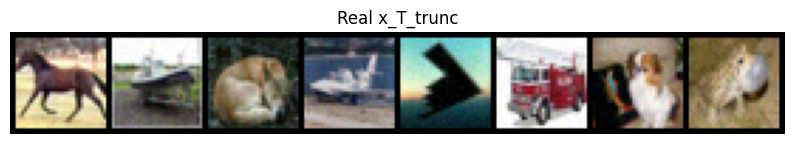

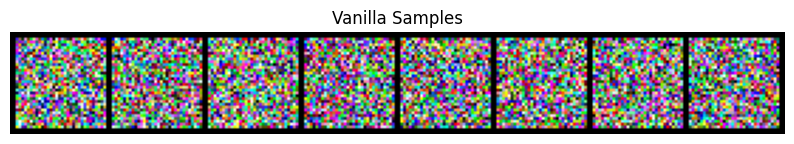

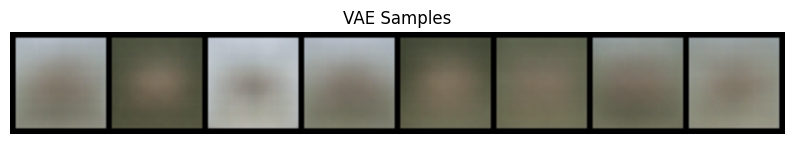

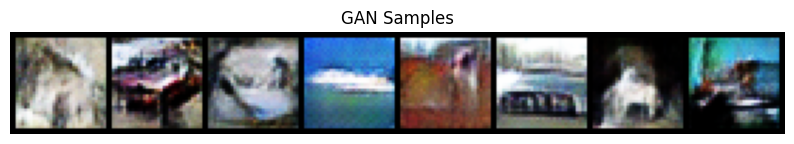

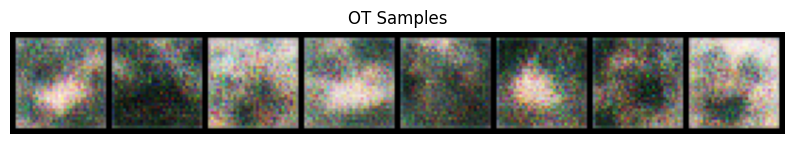

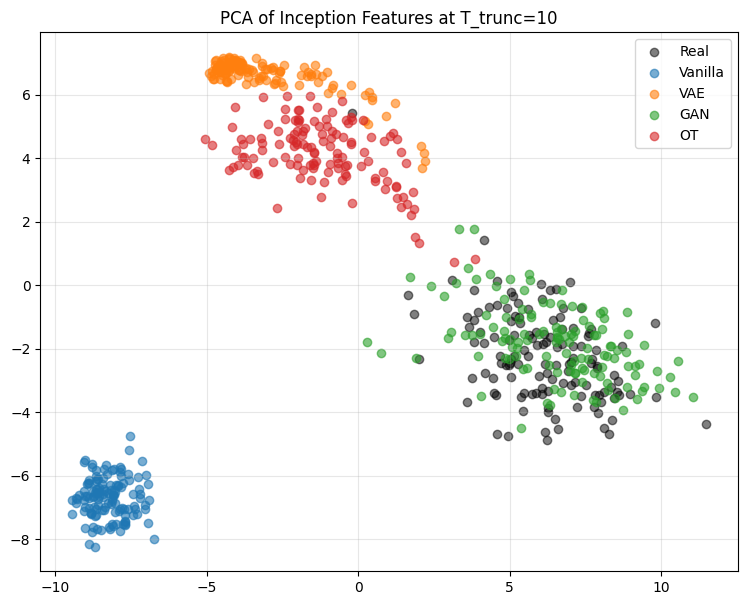

In [20]:
#Helper Functions

def show_image_grid(images, title, nrow=8):
    """Display a grid of images in [-1, 1]."""
    imgs = ((images + 1) / 2).clamp(0, 1).cpu()
    grid = make_grid(imgs, nrow=nrow, padding=2)
    plt.figure(figsize=(10, 4))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis("off")
    plt.title(title)
    plt.show()


def recall_proxy_knn(real_feats, fake_feats, k=3):
    """
    Recall proxy: average distance from real samples
    to their nearest fake neighbors in feature space.
    Lower is better.
    """
    real_np = real_feats.cpu().numpy()
    fake_np = fake_feats.cpu().numpy()
    nbrs = NearestNeighbors(n_neighbors=k).fit(fake_np)
    distances, _ = nbrs.kneighbors(real_np)
    return distances[:, 0].mean()


#Analysis Toolkit

class AnalysisToolkit:
    def __init__(self, device):
        self.device = device

        self.fid = FrechetInceptionDistance(
            feature=64, reset_real_features=False
        ).to(device)

        self.inception = inception_v3(
            pretrained=True, transform_input=False
        ).to(device)
        self.inception.fc = nn.Identity()
        self.inception.eval()

    @torch.no_grad()
    def extract_features(self, images):
        imgs = torch.nn.functional.interpolate(
            images, size=(299, 299), mode="bilinear", align_corners=False
        )
        imgs = (imgs + 1) / 2  # to [0, 1]
        feats = self.inception(imgs)
        return feats.view(feats.size(0), -1)

    def compute_metrics(self, real, fake):
        real_u8 = ((real + 1) / 2 * 255).clamp(0, 255).byte()
        fake_u8 = ((fake + 1) / 2 * 255).clamp(0, 255).byte()

        self.fid.reset()
        self.fid.update(real_u8, real=True)
        self.fid.update(fake_u8, real=False)
        fid_score = self.fid.compute().item()

        real_feats = self.extract_features(real)
        fake_feats = self.extract_features(fake)
        recall_dist = recall_proxy_knn(real_feats, fake_feats)

        return fid_score, recall_dist, real_feats, fake_feats


#Load Fixed Real Data at T_trunc

SAVE_PATH = f"./T_trunc_dataset/target_x_T_{T_TRUNC}.pt"
assert os.path.exists(SAVE_PATH), f"Missing dataset: {SAVE_PATH}"

x_trunc_full = torch.load(SAVE_PATH, map_location=DEVICE)
idx = torch.randperm(x_trunc_full.size(0))[:BATCH_SIZE]
real_x_trunc = x_trunc_full[idx].to(DEVICE)

print(f"Loaded real x_T_trunc batch: {real_x_trunc.shape}")

#Load Prior Models

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(128, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512), nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256), nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128), nn.ReLU(True),
            nn.ConvTranspose2d(128, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        return self.main(z.view(-1, 128, 1, 1))


priors = {}
for name in ["VAE", "GAN", "OT"]:
    try:
        model = Generator().to(DEVICE)
        sd = torch.load(f"{name}_Prior_T{T_TRUNC}.pth", map_location=DEVICE)

        if name == "VAE":
            sd = {k.replace("decoder.", ""): v
                  for k, v in sd.items()
                  if k.startswith("decoder.main.")}

        model.load_state_dict(sd)
        model.eval()
        priors[name] = model
        print(f"Loaded {name} prior.")

    except Exception as e:
        print(f"Skipping {name}: {e}")
        priors[name] = None


# Evaluation

analyzer = AnalysisToolkit(DEVICE)
results = []
feature_bank = {}

with torch.no_grad():
    feature_bank["Real"] = analyzer.extract_features(real_x_trunc).cpu().numpy()

for method in ["Vanilla", "VAE", "GAN", "OT"]:
    print(f"Evaluating {method}...")

    with torch.no_grad():
        if method == "Vanilla":
            fake = torch.randn_like(real_x_trunc)
        else:
            if priors[method] is None:
                continue
            z = torch.randn(BATCH_SIZE, 128, device=DEVICE)
            fake = priors[method](z)

    fid, recall, r_f, f_f = analyzer.compute_metrics(real_x_trunc, fake)
    feature_bank[method] = f_f.cpu().numpy()

    results.append({
        "Method": method,
        "FID": fid,
        "RecallDist": recall,
        "Images": fake
    })

    print(f"  FID: {fid:.2f} | RecallDist: {recall:.3f}")



# eRporting and Visualization

print("\nFINAL RESULTS")
print("-" * 60)
for r in results:
    print(f"{r['Method']:<8} | FID: {r['FID']:<8.2f} | RecallDist: {r['RecallDist']:.3f}")
print("-" * 60)

show_image_grid(real_x_trunc[:8], "Real x_T_trunc")
for r in results:
    show_image_grid(r["Images"][:8], f"{r['Method']} Samples")

#Latent Space PCA

pca = PCA(n_components=2)
all_feats = np.concatenate([feature_bank["Real"]] +
                            [feature_bank[r["Method"]] for r in results])
proj = pca.fit_transform(all_feats)

plt.figure(figsize=(9, 7))
offset = 0
plt.scatter(proj[:BATCH_SIZE, 0], proj[:BATCH_SIZE, 1],
            c="black", alpha=0.5, label="Real")

offset += BATCH_SIZE
for r in results:
    plt.scatter(proj[offset:offset+BATCH_SIZE, 0],
                proj[offset:offset+BATCH_SIZE, 1],
                label=r["Method"], alpha=0.6)
    offset += BATCH_SIZE

plt.title(f"PCA of Inception Features at T_trunc={T_TRUNC}")
plt.legend()
plt.grid(alpha=0.3)
plt.show()
